# Spinal cord gray matter segmentation using deep dilated convolutions

If you use this code, please cite our work:

ArXiv pre-print: https://arxiv.org/abs/1710.01269

Repository: https://github.com/neuropoly/gmseg

`@article{arxiv1710.01269,
  author = {Christian S. Perone, Evan Calabrese, Julien Cohen-Adad},
  title = {Spinal cord gray matter segmentation using deep dilated convolutions},
  journal = {arXiv preprint arXiv:1710.01269},
  year = {2017}
}`

![](../docs/img/architecture.png)
![](../docs/img/segsample.jpg)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 10, 12

import json

import numpy as np

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage as ndi

import nibabel as nib

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.layers import Conv2D, Input
from keras.layers import Reshape, Dropout
from keras.layers import RepeatVector
from keras.layers import Activation, BatchNormalization
from keras.layers import concatenate, GlobalAveragePooling2D

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K

from ipywidgets import interact
import ipywidgets as widgets

Using TensorFlow backend.


In [2]:
K.image_data_format()

'channels_last'

In [3]:
CROP_WIDTH = 200
CROP_HEIGHT = 200

## Center cropping functions

In [4]:
class CroppedRegion(object):
    
    def __init__(self, original_shape, starts, crops):
        self.originalx = original_shape[0]
        self.originaly = original_shape[1]
        self.startx = starts[0]
        self.starty = starts[1]
        self.cropx = crops[0]
        self.cropy = crops[1]
        
    def pad(self, image):
        bef_x = self.startx
        aft_x = self.originalx - (self.startx + self.cropx)
        
        bef_y = self.starty
        aft_y = self.originaly - (self.starty + self.cropy)
        
        padded = np.pad(image,
                        ((bef_y, aft_y),
                         (bef_x, aft_x)),
                        mode="constant")
        return padded

In [5]:
def crop_center(img, cropx, cropy):
    y, x = img.shape
    
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    
    if startx < 0 or starty < 0:
        raise RuntimeError("Negative crop.")
    
    return img[starty:starty + cropy,
               startx:startx + cropx], \
           CroppedRegion((x, y),
                         (startx, starty),
                         (cropx, cropy))

# Network Architecture

In [6]:
smooth_factor = 1.0

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth_factor) / \
           (K.sum(y_true_f) + K.sum(y_pred_f) + smooth_factor)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [7]:
def get_model():
    drop_rate_concat = 0.4
    drop_rate_hidden = 0.4
    bn_momentum = 0.1
    
    inputs = Input((CROP_HEIGHT, CROP_WIDTH, 1))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(momentum=bn_momentum)(conv1)
    conv1 = Dropout(drop_rate_hidden)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(momentum=bn_momentum)(conv1)
    conv1 = Dropout(drop_rate_hidden)(conv1)
    
    # Rate 2
    conv3 = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu',
                   padding='same', name="rate2_1")(conv1)
    conv3 = BatchNormalization(momentum=bn_momentum)(conv3)
    conv3 = Dropout(drop_rate_hidden)(conv3)
    conv3 = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu',
                   padding='same', name="rate2_2")(conv3)
    conv3 = BatchNormalization(momentum=bn_momentum)(conv3)
    conv3 = Dropout(drop_rate_hidden)(conv3)
    
    ############ Branches for ASPP
    
    # Branch for 1x1
    conv3a = Conv2D(32, (3, 3), activation='relu',
                    padding='same', name="branch1x1_1")(conv3)
    conv3a = BatchNormalization(momentum=bn_momentum)(conv3a)
    conv3a = Dropout(drop_rate_hidden)(conv3a)
    conv3a = Conv2D(32, (1, 1), activation='relu',
                    padding='same', name="branch1x1_2")(conv3a)
    conv3a = BatchNormalization(momentum=bn_momentum)(conv3a)
    conv3a = Dropout(drop_rate_hidden)(conv3a)
    
    # Branch for 3x3 rate 6
    conv4 = Conv2D(32, (3, 3), dilation_rate=(6, 6), activation='relu',
                   padding='same', name="rate6_1")(conv3)
    conv4 = BatchNormalization(momentum=bn_momentum)(conv4)
    conv4 = Dropout(drop_rate_hidden)(conv4)
    conv4 = Conv2D(32, (3, 3), dilation_rate=(6, 6), activation='relu',
                   padding='same', name="rate6_2")(conv4)
    conv4 = BatchNormalization(momentum=bn_momentum)(conv4)
    conv4 = Dropout(drop_rate_hidden)(conv4)
    
    # Branch for 3x3 rate 12
    conv5 = Conv2D(32, (3, 3), dilation_rate=(12, 12), activation='relu',
                   padding='same', name="rate12_1")(conv3)
    conv5 = BatchNormalization(momentum=bn_momentum)(conv5)
    conv5 = Dropout(drop_rate_hidden)(conv5)
    conv5 = Conv2D(32, (3, 3), dilation_rate=(12, 12), activation='relu',
                   padding='same', name="rate12_2")(conv5)
    conv5 = BatchNormalization(momentum=bn_momentum)(conv5)
    conv5 = Dropout(drop_rate_hidden)(conv5)
    
    # Branch for 3x3 rate 18
    conv6 = Conv2D(32, (3, 3), dilation_rate=(18, 18), activation='relu',
                   padding='same', name="rate18_1")(conv3)
    conv6 = BatchNormalization(momentum=bn_momentum)(conv6)
    conv6 = Dropout(drop_rate_hidden)(conv6)
    conv6 = Conv2D(32, (3, 3), dilation_rate=(18, 18), activation='relu',
                   padding='same', name="rate18_2")(conv6)
    conv6 = BatchNormalization(momentum=bn_momentum)(conv6)
    conv6 = Dropout(drop_rate_hidden)(conv6)
    
    # Branch for 3x3 rate 24
    conv7 = Conv2D(32, (3, 3), dilation_rate=(24, 24), activation='relu',
                   padding='same', name="rate24_1")(conv3)
    conv7 = BatchNormalization(momentum=bn_momentum)(conv7)
    conv7 = Dropout(drop_rate_hidden)(conv7)
    conv7 = Conv2D(32, (3, 3), dilation_rate=(24, 24), activation='relu',
                   padding='same', name="rate24_2")(conv7)
    conv7 = BatchNormalization(momentum=bn_momentum)(conv7)
    conv7 = Dropout(drop_rate_hidden)(conv7)
    
    # Branch for the global context
    global_pool = GlobalAveragePooling2D()(conv1)
    global_pool = RepeatVector(CROP_HEIGHT*CROP_WIDTH)(global_pool)
    global_pool = Reshape((CROP_HEIGHT, CROP_WIDTH, 32))(global_pool)
    
    ############# Concatenation 
    concat = concatenate([conv3a, conv4, conv5,
                          conv6, global_pool, conv7], axis=3)
    concat = BatchNormalization(momentum=bn_momentum)(concat)
    concat = Dropout(drop_rate_concat)(concat)
    
    amort = Conv2D(64, (1, 1), activation='relu',
                   padding='same', name="amort")(concat)
    amort = BatchNormalization(momentum=bn_momentum)(amort)
    amort = Dropout(drop_rate_hidden)(amort)

    predictions = Conv2D(1, (1, 1), activation='sigmoid',
                         padding='same', name="predictions")(amort)

    model = Model(inputs=[inputs], outputs=[predictions])
    return model

In [8]:
model = get_model()
opt = Adam(lr=0.001)

model.compile(optimizer=opt,
              loss=dice_coef_loss,
              metrics=["accuracy"])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 200, 200, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 200, 200, 32)  320         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 200, 200, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 200, 200, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [9]:
model.load_weights("../models/challenge_model.hdf5")

## Segmentation

In [10]:
def threshold_predictions(predictions, thr=0.999):
    thresholded_preds = predictions[:]
    
    low_values_indices = thresholded_preds <= thr
    thresholded_preds[low_values_indices] = 0

    low_values_indices = thresholded_preds > thr
    thresholded_preds[low_values_indices] = 1
    
    return thresholded_preds

In [11]:
def predict_volume(volume_path, output_path, stats):
    fnib = nib.load(volume_path)
    
    # Get nifti file data, header and affine
    volume_affine = fnib.affine
    volume_header = fnib.header
    volume_data = fnib.get_data()
    
    axial_slices =  []
    crops = []
    
    # Cropping
    for slice_num in xrange(volume_data.shape[2]):
        data = volume_data[..., slice_num]
        data, cropreg = crop_center(data, CROP_HEIGHT, CROP_WIDTH)
        axial_slices.append(data)
        crops.append(cropreg)
    
    axial_slices = np.asarray(axial_slices, dtype=np.float32)
    axial_slices = np.expand_dims(axial_slices, axis=3)
    
    # Normalization
    axial_slices -= stats["mean_train"]
    axial_slices /= stats["std_train"]
    
    # Prediction and Threshold
    # If you have memory issues, just reduce the batch_size
    preds = model.predict(axial_slices, batch_size=8, verbose=True)
    preds = threshold_predictions(preds)
    
    pred_slices = []
    
    # Un-cropping
    for slice_num in xrange(preds.shape[0]):
        pred_slice = preds[slice_num][..., 0]
        pred_slice = crops[slice_num].pad(pred_slice)
        pred_slices.append(pred_slice)
        
    pred_slices = np.asarray(pred_slices, dtype=np.uint8)
    pred_slices = np.transpose(pred_slices, (1, 2, 0))
    
    # Save nifti file
    ni_img = nib.Nifti1Image(pred_slices, volume_affine, volume_header)
    nib.save(ni_img, output_path)

    return pred_slices

In [12]:
volume_path = "../sample_data/t2s_resampled.nii.gz"
nihandle = nib.load(volume_path)

In [13]:
print nihandle.header

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : 
dim_info        : 0
dim             : [  3 640 640  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.          0.25        0.24999999  7.5         1.          1.          1.
  1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.00105023698416
quatern_c       : 0.998035728931
quatern_d       : -0.0601672567427
qoffset_x       : 82.7333755493
q

In [14]:
# Check if the resolution of the volume is 0.25mm x 0.25mm
np.allclose(nihandle.header["pixdim"][1:3], [0.25, 0.25])

True

In [15]:
nidata = nihandle.get_data()
original_slice = nidata[..., 2] # Slice 2

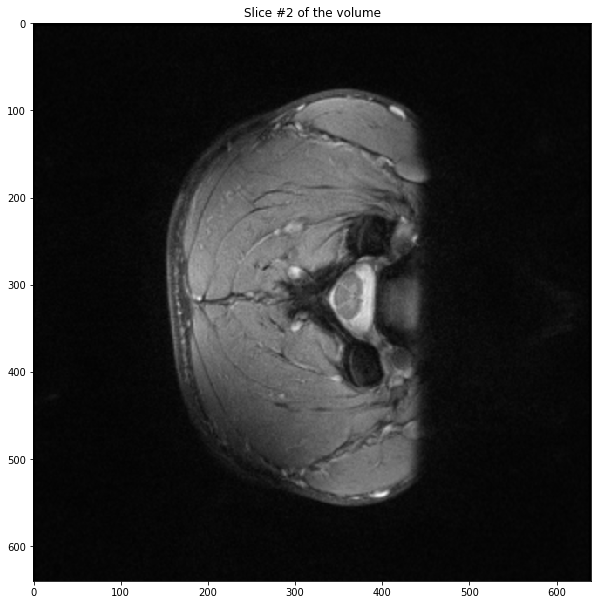

In [16]:
plt.title("Slice #2 of the volume")
plt.imshow(original_slice, cmap="gray")

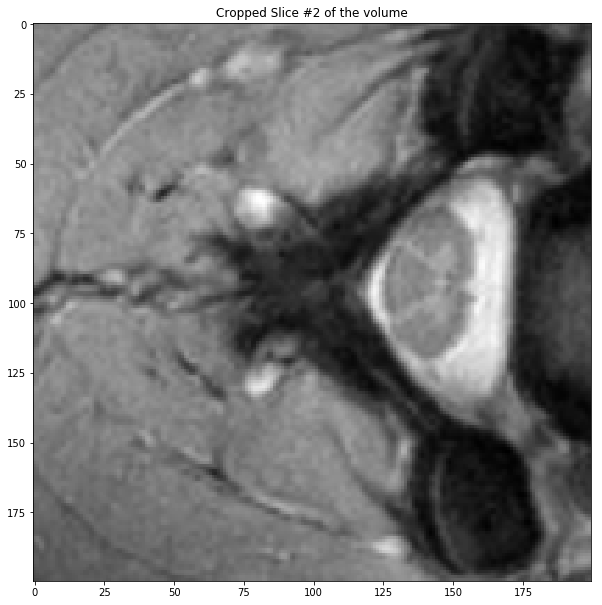

In [17]:
original_slice, _ = crop_center(original_slice, CROP_HEIGHT, CROP_WIDTH)
plt.title("Cropped Slice #2 of the volume")
plt.imshow(original_slice, cmap="gray")

In [18]:
output_volume_path = "segmentation.nii.gz"

In [19]:
# These are the stats of the pre-trained model
# that are used for the volume standardization
with open("../models/challenge_model.json") as fp:
    stats = json.load(fp)
    
# Segmentation will be returned and also saved into the "segmentation.nii.gz" file
# If you don't have GPU, it will take around 15 seconds depending on the machine
preds = predict_volume(volume_path, output_volume_path, stats)

10/10 [==============================] - 13s    


In [20]:
slice2_pred = preds[..., 2]
slice2_pred, _ = crop_center(slice2_pred, CROP_HEIGHT, CROP_WIDTH)

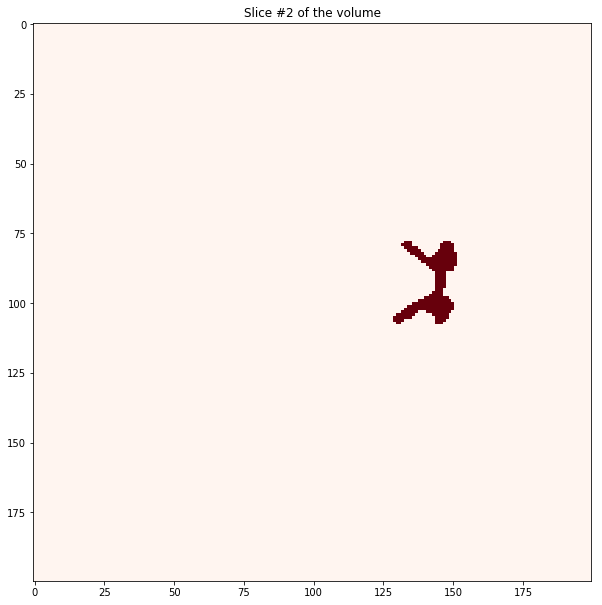

In [21]:
plt.title("Slice #2 of the volume")
plt.imshow(slice2_pred, cmap="Reds")

In [22]:
masked_slice2 = np.ma.masked_where(slice2_pred == 0,
                                   slice2_pred)

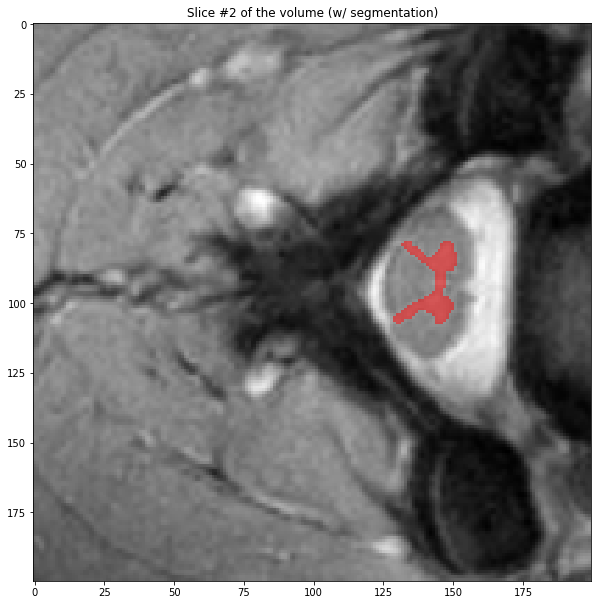

In [23]:
plt.title("Slice #2 of the volume (w/ segmentation)")
plt.imshow(original_slice, cmap="gray")
plt.imshow(masked_slice2, cmap="bwr_r", alpha=0.5)

In [24]:
nidata.shape

(640, 640, 10)

In [27]:
def slice_plot(slice_num):
    slice_pred = preds[..., slice_num]
    slice_pred, _ = crop_center(slice_pred, CROP_HEIGHT, CROP_WIDTH)
    masked_slice_pred = np.ma.masked_where(slice_pred == 0, slice_pred)
    
    orig_slice, _ = crop_center(nidata[..., slice_num], CROP_HEIGHT, CROP_WIDTH)
    
    plt.title("Slice #{} of the volume (w/ segmentation)".format(slice_num))
    plt.imshow(orig_slice, cmap="gray")
    plt.imshow(masked_slice_pred, cmap="bwr_r", alpha=0.5)
    

In [28]:
z_slicer = widgets.IntSlider(min=0, max=preds.shape[2]-1, step=1, value=0)
interact(slice_plot, slice_num=z_slicer);

interactive(children=(IntSlider(value=0, description=u'slice_num', max=9), Output()), _dom_classes=('widget-interact',))